# Imports

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from geopy.distance import geodesic

# Preprocessing

In [181]:
hubert = pd.read_csv("./data/hubert.csv")
meteo = pd.read_csv("./data/meteo_france.csv")
adresse = pd.read_csv("./data/adresse.csv", sep=";")

In [182]:
# Convert the 'timestamp' column to a datetime type
hubert['timestamp_clean'] = pd.to_datetime(hubert['timestamp'])
meteo['timestamp_clean'] = pd.to_datetime(meteo['timestamp'])

# Create new 'day' and 'hour' columns
hubert['day'] = hubert['timestamp_clean'].dt.date
meteo['day'] = meteo['timestamp_clean'].dt.date
hubert['hour'] = hubert['timestamp_clean'].dt.hour
meteo['hour'] = meteo['timestamp_clean'].dt.hour


hubert['day_of_week'] = hubert['timestamp_clean'].dt.day_name()
hubert['day_of_week'] = pd.Categorical(hubert['day_of_week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
hubert['day_of_week_encoded'] = hubert['day_of_week'].cat.codes
hubert['arrondissement_start'] = hubert['raw_start_location'].str.extract(r'Paris (\d+)e Arrondissement')
hubert['arrondissement_end'] = hubert['raw_end_location'].str.extract(r'Paris (\d+)e Arrondissement')
hubert

,timestamp,raw_start_location,raw_end_location,fee,timestamp_clean,day,hour,day_of_week,day_of_week_encoded,arrondissement_start,arrondissement_end
0,2023-01-18 22:21:35,"145, Rue Belliard, Paris 18e Arrondissement","315, Rue de Charenton, Paris 12e Arrondissement",16.57,2023-01-18 22:21:35,2023-01-18,22,Wednesday,2,18,12
1,2023-01-19 20:31:27,"127, Rue de Charenton, Paris 12e Arrondissement","1, Square de la Dordogne, Paris 17e Arrondisse...",18.61,2023-01-19 20:31:27,2023-01-19,20,Thursday,3,12,17
2,2023-01-25 19:40:10,"8, Rue Richard Lenoir, Paris 11e Arrondissement","9, Rue de Cherbourg, Paris 15e Arrondissement",13.15,2023-01-25 19:40:10,2023-01-25,19,Wednesday,2,11,15
3,2023-01-14 10:07:15,"6, Rue Guisarde, Paris 6e Arrondissement","28, Rue Guynemer, Paris 6e Arrondissement",5.00,2023-01-14 10:07:15,2023-01-14,10,Saturday,5,6,6
4,2023-01-01 21:23:11,"2, Rue Cognacq-Jay, Paris 7e Arrondissement","115, Boulevard du Montparnasse, Paris 6e Arron...",5.00,2023-01-01 21:23:11,2023-01-01,21,Sunday,6,7,6
...,...,...,...,...,...,...,...,...,...,...,...
9995,2023-01-14 20:46:20,"31, Rue du Transvaal, Paris 20e Arrondissement","122, Avenue Emile Zola, Paris 15e Arrondissement",8.48,2023-01-14 20:46:20,2023-01-14,20,Saturday,5,20,15
9996,2023-01-08 10:39:42,"2, Passage Vérité, Paris 1er Arrondissement","94, Rue Raynouard, Paris 16e Arrondissement",8.28,2023-01-08 10:39:42,2023-01-08,10,Sunday,6,NaN,16
9997,2023-01-03 15:44:24,"30, Rue des Grands Moulins, Paris 13e Arrondis...","40, Avenue de Villiers, Paris 17e Arrondissement",5.00,2023-01-03 15:44:24,2023-01-03,15,Tuesday,1,13,17
9998,2023-01-09 19:44:26,"43, Avenue Hoche, Paris 8e Arrondissement","44, Rue Bargue, Paris 15e Arrondissement",5.00,2023-01-09 19:44:26,2023-01-09,19,Monday,0,8,15


In [183]:
adresse["adresse_complete"] = adresse['numero'].fillna('').astype(str) + adresse['rep'].fillna('') + ', ' + adresse['nom_voie'] + ', ' + adresse['nom_commune']
adresse_xs = adresse[["adresse_complete", "wgs84"]]
adresse_xs[['latitude', 'longitude']] = adresse_xs['wgs84'].str.split(',', expand=True).astype(float)
adresse_xs

,adresse_complete,wgs84,latitude,longitude
0,"72, Quai de Jemmapes, Paris 10e Arrondissement","48.87146,2.365695",48.871460,2.365695
1,"84, Quai de Jemmapes, Paris 10e Arrondissement","48.872411,2.364956",48.872411,2.364956
2,"104, Quai de Jemmapes, Paris 10e Arrondissement","48.873703,2.363951",48.873703,2.363951
3,"136, Quai de Jemmapes, Paris 10e Arrondissement","48.876287,2.365038",48.876287,2.365038
4,"193, Quai de Jemmapes, Paris 10e Arrondissement","48.880371,2.368592",48.880371,2.368592
...,...,...,...,...
150301,"61b, Avenue de la Motte-Picquet, Paris 15e Arr...","48.849449,2.298775",48.849449,2.298775
150302,"54b, Avenue de la Motte-Picquet, Paris 15e Arr...","48.85023,2.299243",48.850230,2.299243
150303,"57b, Avenue de la Motte-Picquet, Paris 15e Arr...","48.849687,2.299124",48.849687,2.299124
150304,"53b, Avenue de la Motte-Picquet, Paris 15e Arr...","48.85004,2.299645",48.850040,2.299645


In [184]:
df = pd.merge(hubert, meteo, on=['day', 'hour'], how='inner')
df = pd.merge(df, adresse_xs, left_on=['raw_start_location'], right_on=['adresse_complete'], how='inner', suffixes=("", "_start"))
df = pd.merge(df, adresse_xs, left_on=['raw_end_location'], right_on=['adresse_complete'], how='inner', suffixes=("_start", "_end"))

df = df[["fee", "day", "hour", "rain_level", "temperature", "latitude_start", "longitude_start", "latitude_end", "longitude_end", "day_of_week_encoded", "arrondissement_start", "arrondissement_end"]]
df['distance'] = df.apply(lambda row: float(geodesic((row['latitude_start'], row['longitude_start']), (row['latitude_end'], row['longitude_end'])).kilometers), axis=1)
df

,fee,day,hour,rain_level,temperature,latitude_start,longitude_start,latitude_end,longitude_end,day_of_week_encoded,arrondissement_start,arrondissement_end,distance
0,16.57,2023-01-18,22,0,7,48.896081,2.333521,48.833631,2.395160,2,18,12,8.287566
1,5.00,2023-01-18,22,0,7,48.857882,2.366562,48.862076,2.363896,2,3,3,0.505766
2,8.86,2023-01-18,22,0,7,48.845263,2.293003,48.875051,2.313647,2,15,8,3.642543
3,5.79,2023-01-18,22,0,7,48.897029,2.345385,48.863072,2.349647,2,18,NaN,3.789187
4,24.97,2023-01-18,22,0,7,48.891797,2.377772,48.827877,2.373640,2,19,13,7.114816
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8574,5.00,2023-01-31,4,0,6,48.839811,2.323570,48.856335,2.309538,1,14,7,2.106497
8575,5.00,2023-01-31,4,0,6,48.848525,2.318700,48.845361,2.263516,1,7,16,4.065525
8576,5.00,2023-01-03,3,0,5,48.846032,2.301622,48.858150,2.352283,1,15,4,3.954614
8577,5.41,2023-01-18,4,0,8,48.851315,2.264902,48.861000,2.351261,2,16,4,6.428092


# Visualisation

In [185]:
relevant_features = ['fee', 'hour', 'rain_level', 'temperature', 'distance', "day_of_week_encoded", "arrondissement_start", "arrondissement_end"]

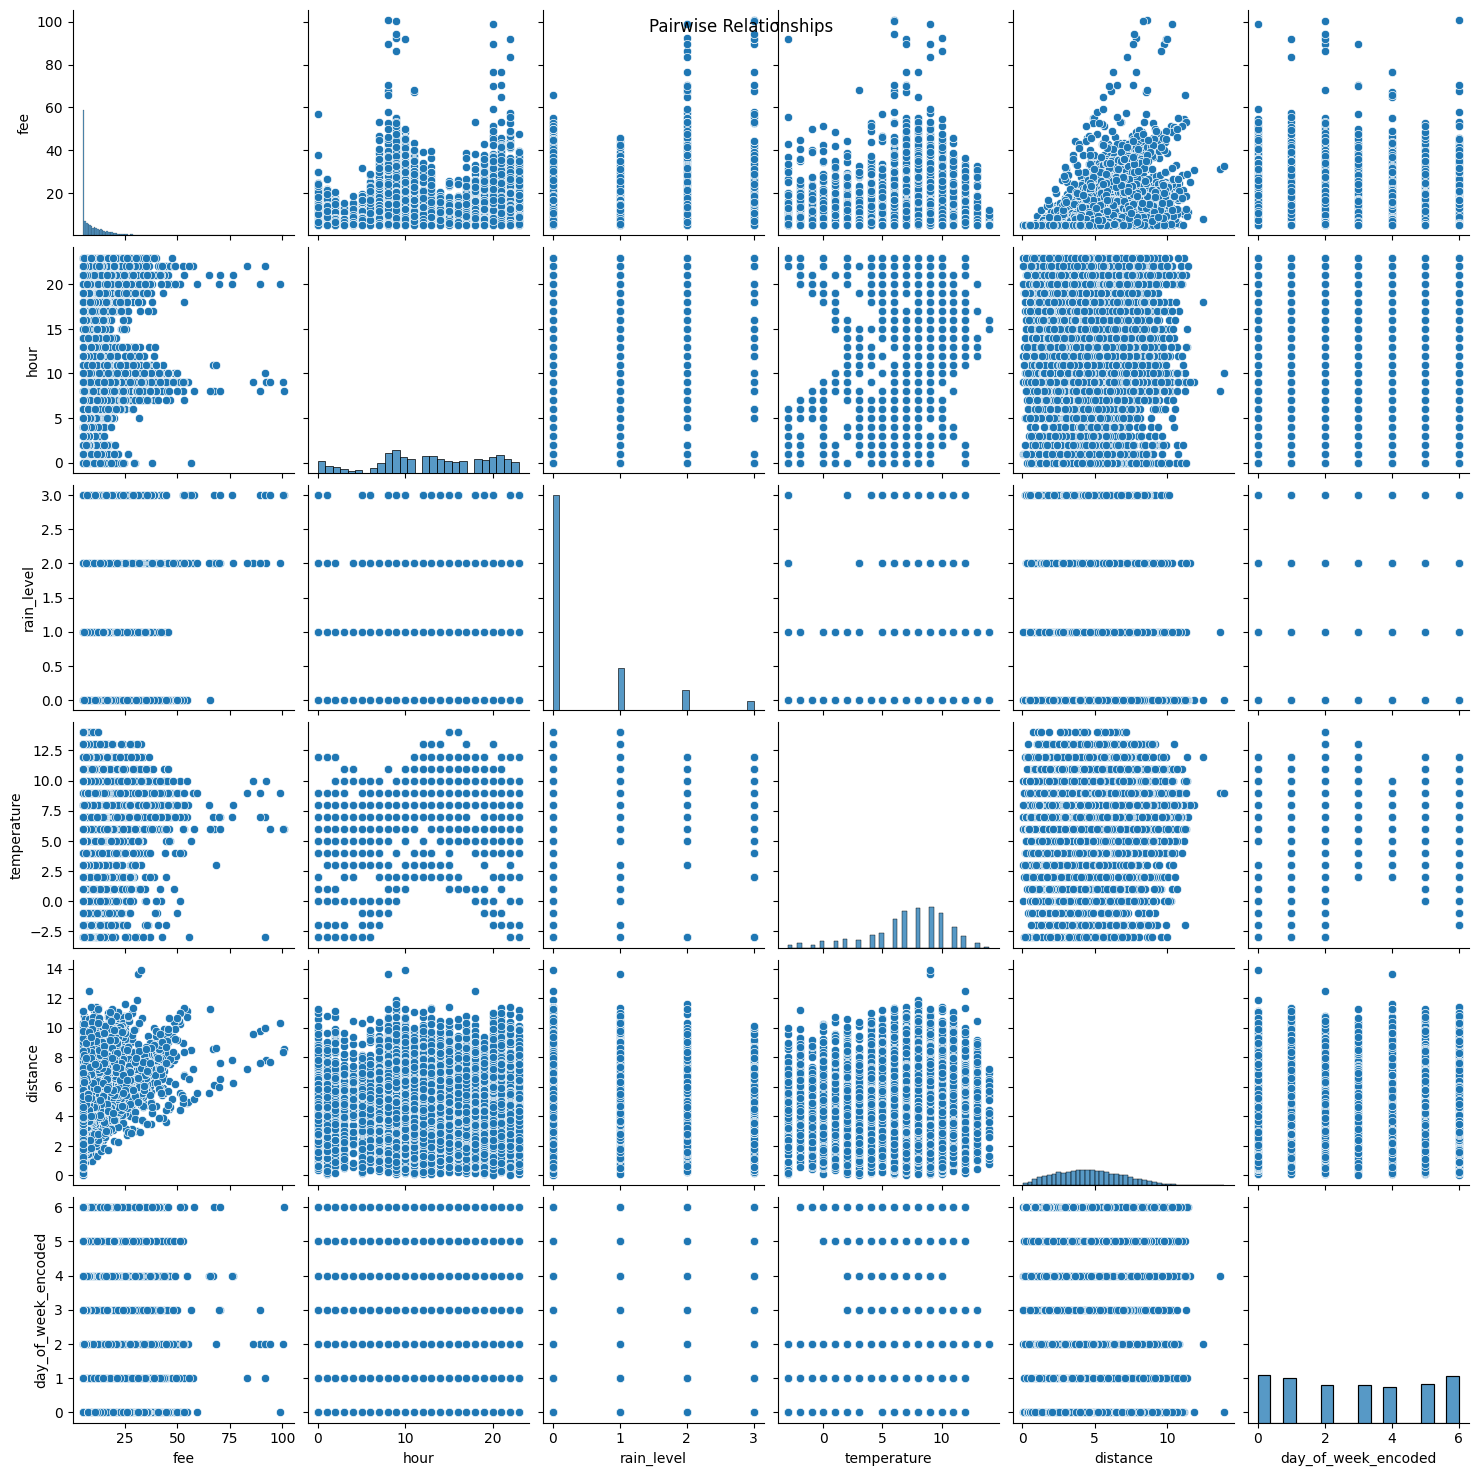

In [186]:
sns.pairplot(df[relevant_features])
plt.suptitle('Pairwise Relationships')
plt.show()


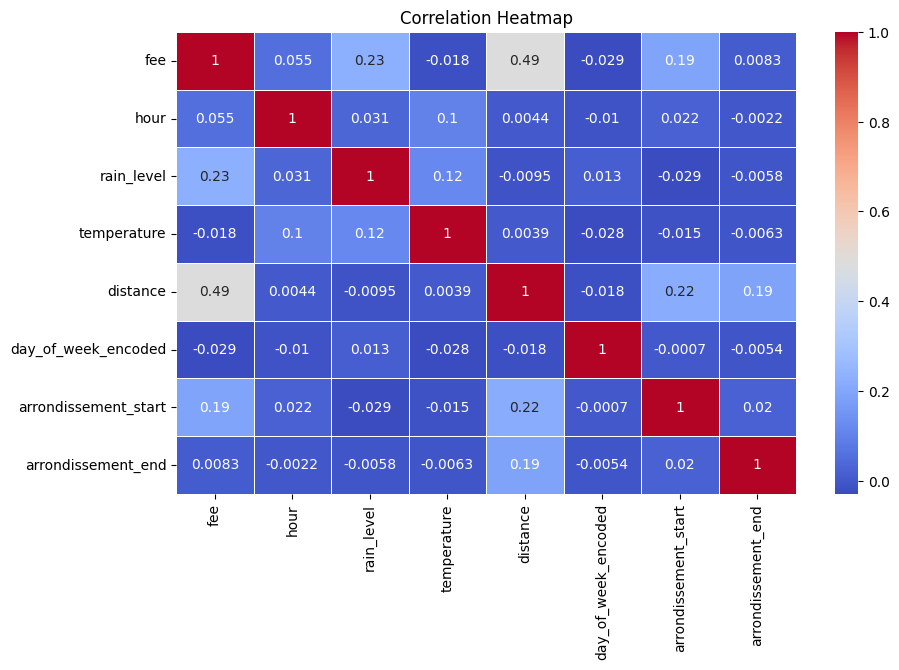

In [187]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[relevant_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# Processing

## Predict the fee

In [202]:
# Split the data into train, test, and validation sets using scikit-learn
train_size = 0.6
val_size = 0.2
test_size = 0.2

df.dropna(inplace=True)

X = df[['hour', 'rain_level', 'temperature', 'distance', 'day_of_week_encoded', 'arrondissement_start', 'arrondissement_end']]
y = df['fee']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (val_size + test_size), random_state=42)

# Create and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 3.4710639692036724


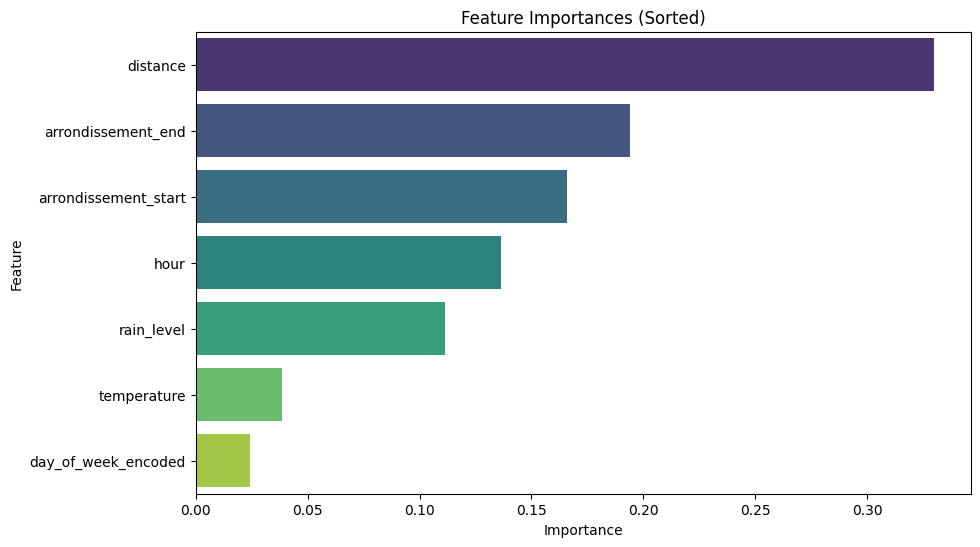

In [203]:
importances = model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, orient='h', palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Sorted)')
plt.show()

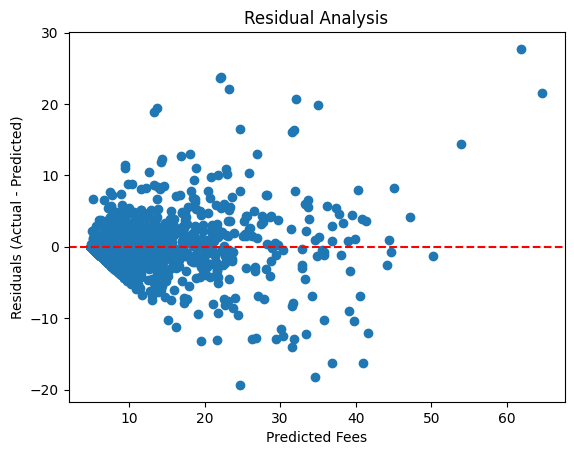

In [199]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Fees")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Analysis")
plt.axhline(0, color='red', linestyle='--')
plt.show()

Résultats + analsyes

RMSE = 3.4
Le RMSE est faible, ce qui n'est pas surprenant, on sait que Hubert utilise la distance comme principale variable d'établissement de son prix.

Pour améliorer le modèle, on pourrait le comparer à d'autres classifiers, et continuer le feature engineering.
J'ai gardé un set de validation que le modèle n'a jamais vu.

Les feature importances du modèle montrent qu'en plus de la distance, Hubert utilise les quartiers, les heures, et la présence de pluie pour calculer le prix de la course.
Il pourrait utiliser la température par exemple, ou le jour de la semaine, qui ne sont pas utilisés.
